In [2]:
import os
import sys
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import math
import statistics
from datetime import datetime
import collections


from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

# loading the data

In [3]:
df = pd.read_csv('movielens-100k-dataset/ml-100k/udata.csv',sep=";", header=0, engine="python")
user = pd.read_csv('movielens-100k-dataset/ml-100k/uuser.csv',sep=";", header=0, engine ="python")
genre = pd.read_csv('movielens-100k-dataset/ml-100k/ugenre.csv',sep=";", header=0, engine = "python")

### preprocessing the user dataset

In [4]:
user.head(2)

,id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [5]:
user.shape

(943, 5)

 We consider "gender" as the sensitive attribute. F is the protected value and M is the unprotected value.

In [6]:
user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
user.head(3)

,id,age,gender,occupation,zipcode,is_pro
0,1,24,M,technician,85711,0
1,2,53,F,other,94043,1
2,3,23,M,writer,32067,0


In [7]:
user[['id', 'is_pro']].head()

,id,is_pro
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1


In [8]:
global pro_users
global unpro_users

In [9]:
pro_users = []
unpro_users = []

for i, row in user[['id', 'is_pro']].iterrows():
    if row['is_pro'] == 1:
        pro_users.append(row['id'])
    else:
        unpro_users.append(row['id'])
        
print('protected users', len(pro_users))
print('unprotected users', len(unpro_users))

protected users 273
unprotected users 670


# Consumer-side Fairness Metrics

0: uid, 1: iid, 2:r_ui, 3: est

g: disadvantaged, -g: advantaged

In [10]:
def avg_score(df_i, itemid, users, est=False):  
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
    
    return df_i.loc[(df_i['uid']).isin(users), pred_type].mean()
     

In [11]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid'][:2]):

        item_df = p_df[p_df['iid'] == itemid]

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
        
    return sum_err/np.unique(p_df['iid']).size
    

In [12]:
def abs_unfairness(p_df):
    
    '''
    absolute unfairness measures inconsistency in absolute estimation error across user types
    
    Absolute unfairness is unsigned, so it captures a single statistic representing the quality of prediction 
    for each user type. If one user type has small reconstruction error and the other user type has large 
    reconstruction error, one type of user has the unfair advantage of good recommendation, while the
    other user type has poor recommendation.
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid'][:2]):

        item_df = p_df[p_df['iid'] == itemid]

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(abs(e_g_y - e_g_r) - abs(e_ng_y - e_ng_r))
        
    return sum_err/np.unique(p_df['iid']).size


In [13]:
def underestimation_unfairness(p_df):
    
    '''
    underestimation unfairness measures inconsistency in how much the predictions underestimate the true ratings
    
    Underestimation unfairness is important in settings where missing recommendations are more critical
    than extra recommendations. 
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid'][:2]):

        item_df = p_df[p_df['iid'] == itemid]

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(max([0,(e_g_r - e_g_y)]) - max([0,(e_ng_r - e_ng_y)]))
        
    return sum_err/np.unique(p_df['iid']).size


In [14]:
def overestimation_unfairness(p_df):
    
    '''
    Overestimate unfairness measures inconsistency in how much the predictions overestimate the true ratings
    
    Overestimation unfairness may be important in settings where users may be overwhelmed by recommendations, so providing too many recommendations would be especially detrimental. For example,
    if users must invest large amounts of time to evaluate each recommended item, overestimating
    essentially costs the user time. Thus, uneven amounts of overestimation could cost one type of user
    more time than the other.
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid'][:2]):

        item_df = p_df[p_df['iid'] == itemid]

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(max([0,(e_g_y - e_g_r)]) - max([0,(e_ng_y - e_ng_r)]))
        
    return sum_err/np.unique(p_df['iid']).size


In [15]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(preds_df['uid']).isin(pro_users), 'est'].mean()
    e_ng_y = p_df.loc[(preds_df['uid']).isin(unpro_users), 'est'].mean()
    
    
    return abs(e_g_y - e_ng_y)
    

# calibration
# statistical parity / demographic parity
# ppr

In [16]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 100000


# AL

In [32]:
# 16 gaps of data
data_big = []
for i in range(17):
    data_big.append((i*5000))
data_big[0] = 1


data_med = []
for i in range(101):
    data_med.append((i*200))
data_med[0] = 1


data_sm = []
for i in range(601):
    data_sm.append((i*5))
data_sm[0] = 1

#### how many samples should I collect for the next round? I have 16 gaps/trials.
use the variable data for it

In [33]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))


# We'll use the famous SVD algorithm.
algo = SVD()


# Active learning 4 - Attention Based Popularity
df_1 = df.pivot(index = 'user', columns ='item', values = 'rating')

df_numpy = df_1.values

In [34]:
print('#user', '#item')
print(df_numpy.shape)

#user #item
(943, 1682)


In [35]:
tstart = datetime.now()
numberCol = []
# for every item
for column in df_numpy.T:
    
    i = 0
    for eachValue in column:
        
        # if the rating existed
        # all the ratings are whole values, but this should change for other ratings
        if (eachValue == 1 or eachValue == 2 or eachValue == 3 
        or eachValue == 4 or eachValue == 5):
            i=i+1
            
    # how many ratings do we have for each item?
    numberCol.append(i)


item = np.array(numberCol)
item = pd.DataFrame(item, columns = ["item"])

# take only the most popular item
# we have the count of ratings for each item, now sort them!
item = item.sort_values(by=["item"], ascending = False)
index = item.index.tolist()

# create a training set, which consists of the same user/item/rating data,
# but is sorted based on item popularity
trainact = pd.DataFrame(columns=['user','item','rating'])

for i in index:
    trainact = trainact.append(df.loc[df['item']==i],ignore_index = True)

trainact = trainact.drop_duplicates(keep ='first')



In [36]:
print('#item','#user')
print(df_numpy.T.shape)

#item #user
(1682, 943)


In [37]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        if row.uid in pro_users:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

# Attention Based popularity

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

In [38]:
# general RMSE
rmse_al = [] # active learning
rmse_ran = [] # random

# seperating the protected and unprotected groups
rmse_al_pro = []
rmse_al_unpro = []

rmse_ran_pro = []
rmse_ran_unpro = []

# non parity
np_al = []
np_ran = []

# value unfairness
vu_al = []
vu_ran = []

# absolute value unfairness
au_al = []
au_ran = []

# over estimation unfairness
ou_al = []
ou_rand = []

#under estimation unfairness
uu_al = []
uu_rand = []

In [39]:
# test data
# Return a random sample of user, item, rating rows
test = df.sample(n = 20000)


# for i in data_big:
# for i in data_med:
for i in data_sm:

    algo = SVD()
    algoran = SVD()

#     # test data
#     # Return a random sample of user, item, rating rows
#     test = df.sample(n = 20000)

    # if we have 2 exactly the same items, keep=False removes both.
    # Here we are removing the test from the train.
    trainact1 = pd.concat([test, trainact]).drop_duplicates(keep=False) 
    trainact1 = trainact1.head(i)
    # every time pick i item from the whole data, acttrain has a different ordering

    # keep=false, drop all duplicates
    train = pd.concat([df, test]).drop_duplicates(keep=False)
    train = train.sample(n = i) # pick i item from the train randomly

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']], reader).build_full_trainset()
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']], reader).build_full_trainset()
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

    
    ########################## active learning ##############################
    algo.fit(trainsetact)
    predictions = algo.test(testset)

    # RMSE
    rmse_al.append(accuracy.rmse(predictions, verbose=False))
    
    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictions)    
    rmse_al_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_al_unpro.append(accuracy.rmse(unpro_pr, verbose=False))
    
    
    ######################### random ##################################
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    # RMSE
    rmse_ran.append(accuracy.rmse(predictionsran, verbose=False))
    
    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictionsran)    
    rmse_ran_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_ran_unpro.append(accuracy.rmse(unpro_pr, verbose=False))

    
    ##### consumer side fairness metrics
    # fairness metrics
    preds_df = pd.DataFrame(predictions)
    preds_al_df = pd.DataFrame(predictionsran)
    
    # non-parity
    np_al.append(non_parity(preds_al_df))
    np_ran.append(non_parity(preds_df))
    
    # value unfairness
    vu_al.append(value_unfairness(preds_al_df))
    vu_ran.append(value_unfairness(preds_df))
    
    # absolute unfairness
    au_al.append(abs_unfairness(preds_al_df))
    au_ran.append(abs_unfairness(preds_df))
    
    # over-estimation unfairness
    ou_al.append(overestimation_unfairness(preds_al_df))
    ou_rand.append(overestimation_unfairness(preds_df))
    
    #under-estimation unfairness
    uu_al.append(underestimation_unfairness(preds_al_df))
    uu_rand.append(underestimation_unfairness(preds_df))
    
tend = datetime.now()    
print("\n Active learning in ms : \n")
print(tend-tstart)


 Active learning in ms : 

0:19:12.714320


# RMSE - Attention based popularity & Random

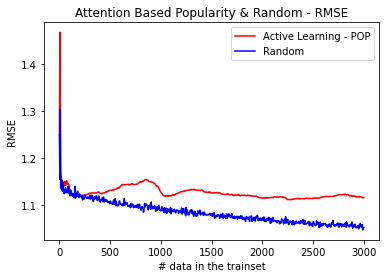

In [40]:
# plt.plot(data_big, rmse_al,'r')
# plt.plot(data_big, rmse_ran,'b')

# plt.plot(data_med, rmse_al,'r')
# plt.plot(data_med, rmse_ran,'b')

plt.plot(data_sm, rmse_al,'r')
plt.plot(data_sm, rmse_ran,'b')


# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Popularity & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['Active Learning - POP', 'Random'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - RMSE - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - RMSE - medium gaps - fixed test.png')


plt.savefig('./figures/june22/Attention Based Popularity & Random\
- RMSE - small gaps - fixed test.png')


# pro vs unpro RMSE

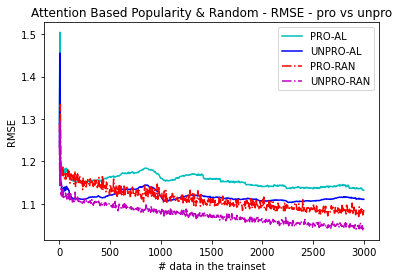

In [41]:
# plt.plot(data_big,rmse_al_pro,'c')
# plt.plot(data_big,rmse_al_unpro,'b')

# plt.plot(data_big,rmse_ran_pro,'r-.')
# plt.plot(data_big,rmse_ran_unpro,'m-.')


# plt.plot(data_med,rmse_al_pro,'c')
# plt.plot(data_med,rmse_al_unpro,'b')

# plt.plot(data_med,rmse_ran_pro,'r-.')
# plt.plot(data_med,rmse_ran_unpro,'m-.')



plt.plot(data_sm,rmse_al_pro,'c')
plt.plot(data_sm,rmse_al_unpro,'b')

plt.plot(data_sm,rmse_ran_pro,'r-.')
plt.plot(data_sm,rmse_ran_unpro,'m-.')


# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Popularity & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['PRO-AL', 'UNPRO-AL', 'PRO-RAN', 'UNPRO-RAN'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - RMSE - pro vs unprov - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - RMSE - pro vs unprov - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random\
- RMSE - pro vs unprov - small gaps - fixed test.png')

## non parity

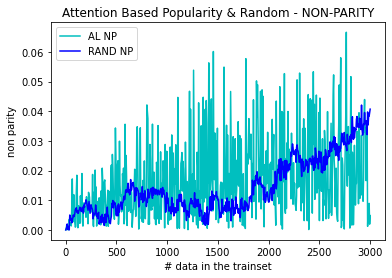

In [42]:
# plt.plot(data_big,np_al,'c')
# plt.plot(data_big,np_ran,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

plt.plot(data_sm,np_al,'c')
plt.plot(data_sm,np_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['AL NP', 'RAND NP'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - NON-PARITY - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - NON-PARITY - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random\
- NON-PARITY - small gaps - fixed test.png')

### value unfairness

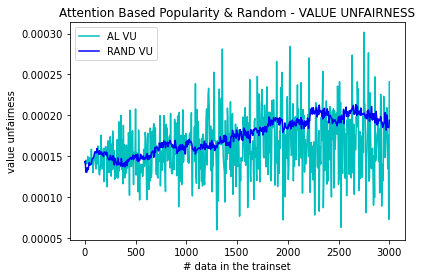

In [43]:
# plt.plot(data_big,vu_al,'c')
# plt.plot(data_big,vu_ran,'b')

# plt.plot(data_med, vu_al,'c')
# plt.plot(data_med, vu_ran,'b')

plt.plot(data_sm, vu_al,'c')
plt.plot(data_sm, vu_ran,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['AL VU', 'RAND VU'], loc='upper left')

# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - VALUE UNFAIRNESS - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - VALUE UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random\
- VALUE UNFAIRNESS - small gaps - fixed test.png')

### absolute unfairness

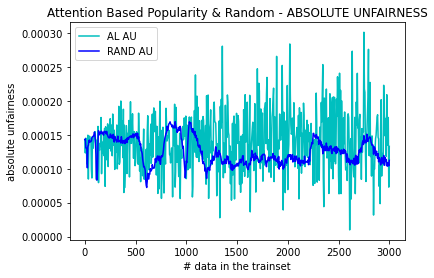

In [44]:
# plt.plot(data_big,au_al,'c')
# plt.plot(data_big,au_ran,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

plt.plot(data_sm,au_al,'c')
plt.plot(data_sm,au_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['AL AU', 'RAND AU'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random - \
# ABSOLUTE UNFAIRNESS - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random - \
# ABSOLUTE UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random - \
ABSOLUTE UNFAIRNESS - small gaps - fixed test.png')


### over estimation unfairness

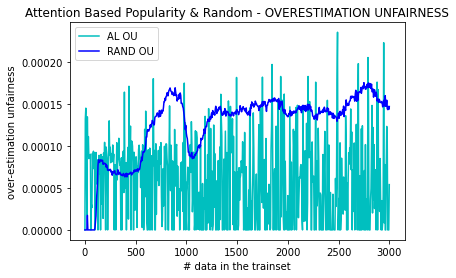

In [45]:
# plt.plot(data_big,ou_al,'c')
# plt.plot(data_big,ou_rand,'b')

# plt.plot(data_med, ou_al,'c')
# plt.plot(data_med, ou_rand,'b')

plt.plot(data_sm, ou_al,'c')
plt.plot(data_sm, ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['AL OU', 'RAND OU'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - OVERESTIMATION UNFAIRNESS - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - OVERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random\
- OVERESTIMATION UNFAIRNESS - small gaps - fixed test.png')

### under estimation unfairness

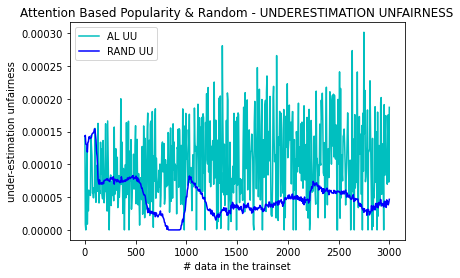

In [46]:
# plt.plot(data_big, uu_al,'c')
# plt.plot(data_big, uu_rand,'b')

# plt.plot(data_med, uu_al,'c')
# plt.plot(data_med, uu_rand,'b')

plt.plot(data_sm, uu_al,'c')
plt.plot(data_sm, uu_rand,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['AL UU', 'RAND UU'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - UNDERESTIMATION UNFAIRNESS - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Popularity & Random\
- UNDERESTIMATION UNFAIRNESS - small gaps - fixed test.png')

# Attention Based SQRT(Popularity) * Variance

This is a “balanced” strategy as it tries to collect many ratings but also taking into account 
their relative informativeness. This is achieved by scoring an item with the square root of the popularity multiplied
by the variance of the item’s ratings. The distribution of the items’ popularity is exponential
while the distribution of the variance is more similar to a normal distribution. 
Indeed, there is a huge difference among the popularity scores of few popular and many
unpopular items. multiplying variance and popularity reduces the weight of popularity. 
Therefore we end up with items that are popular and at the same time have controvertial ratings.

In [47]:
# 16 gaps of data

# data = []
# for i in range(101):
#     data.append((i*200))
# data[0] = 1

# A reader is still needed but only the rating_scale param is requiered.

reader = Reader(rating_scale=(1, 5))

# We'll use the famous SVD algorithm.

algo = SVD()

# Active learning 4 - Attention Based Square(Popularity) * Variance

df_1 = df.pivot(index = 'user', columns ='item', values = 'rating')

df_numpy = df_1.values

np.warnings.filterwarnings('ignore')

df_mask = df_numpy > 0
df_mask = df_mask.astype(int)

rmse_al = []
rmse_ran = []


# for fairness metrics
rmse_al_pro = []
rmse_al_unpro = []

rmse_ran_pro = []
rmse_ran_unpro = []

np_al = []
np_ran = []

vu_al = []
vu_ran = []

au_al = []
au_ran = []

ou_al = []
ou_rand = []

uu_al = []
uu_rand = []


# Popularity
tstart = datetime.now()

numberCol = []
for column in df_numpy.T:
    i = 0
    for eachValue in column:
        if eachValue == 1 or eachValue == 2 or eachValue == 3 or eachValue == 4 or eachValue == 5:
            i=i+1
    numberCol.append(i)

item_popularity = np.array(numberCol)

item_popularity_normalize = []
for i in range(len(item_popularity)):
    item_popularity_normalize.append((item_popularity[i]-min(item_popularity))/
                                     (max(item_popularity)-min(item_popularity)))

# Variance

colVariance = []
for eachCol in df_numpy.T:
    colVariance.append(np.nanvar(eachCol))

item_variance = np.array(colVariance)

# Product

item = np.sqrt(item_popularity_normalize)*item_variance

item = pd.DataFrame(item, columns = ["item"])

# take only the most popular item

item = item.sort_values(by=["item"], ascending = False)
index = item.index.tolist()

trainact = pd.DataFrame(columns=['user','item','rating'])

for i in index:
    trainact = trainact.append(df.loc[df['item']==i],ignore_index = True)

trainact = trainact.drop_duplicates()

tend = datetime.now()


# this action looks like having a k-fold cross validation
test = df.sample(n=20000, random_state=1)

# for i in data_big:
# for i in data_med:
for i in data_sm:

    algo = SVD()
    algoran = SVD()

#     # this action looks like having a k-fold cross validation
#     test = df.sample(n=20000, random_state=1)

    trainact1 = pd.concat([trainact, test]).drop_duplicates(keep=False)
    trainact1 = trainact1.head(i)

    train = pd.concat([df, test]).drop_duplicates(keep=False)
    train = train.sample(n = i)

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']], reader).build_full_trainset()
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']],reader).build_full_trainset()
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

    ### active learning ###
    algo.fit(trainsetact)
    predictions = algo.test(testset)

    rmse_al.append(accuracy.rmse(predictions, verbose=False))

    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictions)    
    rmse_al_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_al_unpro.append(accuracy.rmse(unpro_pr, verbose=False))
    
    
    
    ### random ###
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    rmse_ran.append(accuracy.rmse(predictionsran, verbose=False))
    
    
    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictionsran)    
    rmse_ran_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_ran_unpro.append(accuracy.rmse(unpro_pr, verbose=False))
    
    
    ##### consumer side fairness metrics
    # fairness metrics
    preds_df = pd.DataFrame(predictions)
    preds_al_df = pd.DataFrame(predictionsran)
    
    # non-parity
    np_al.append(non_parity(preds_al_df))
    np_ran.append(non_parity(preds_df))
    
    # value unfairness
    vu_al.append(value_unfairness(preds_al_df))
    vu_ran.append(value_unfairness(preds_df))
    
    # absolute unfairness
    au_al.append(abs_unfairness(preds_al_df))
    au_ran.append(abs_unfairness(preds_df))
    
    # over-estimation unfairness
    ou_al.append(overestimation_unfairness(preds_al_df))
    ou_rand.append(overestimation_unfairness(preds_df))
    
    #under-estimation unfairness
    uu_al.append(underestimation_unfairness(preds_al_df))
    uu_rand.append(underestimation_unfairness(preds_df))
    

# print(rmse_al)
print(" Active learning in ms : ")
print(tend-tstart)
# print(rmse_ran)

 Active learning in ms : 
0:00:08.426194


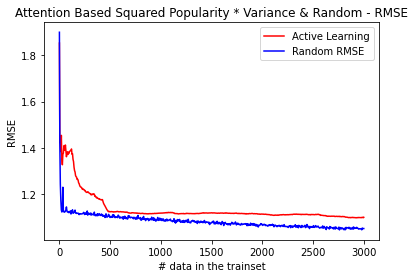

In [48]:
# plt.plot(data_big,rmse_al,'r')
# plt.plot(data_big,rmse_ran,'b')

# plt.plot(data_med,rmse_al,'r')
# plt.plot(data_med,rmse_ran,'b')

plt.plot(data_sm,rmse_al,'r')
plt.plot(data_sm,rmse_ran,'b')

# plt.axis([0,20000,0.5,2.0])
plt.title('Attention Based Squared Popularity * Variance & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['Active Learning', 'Random RMSE'], loc='upper right')
# plt.show()

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE - big gaps - fixed test.png')
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- RMSE - small gaps - fixed test.png')


## pro vs unpro

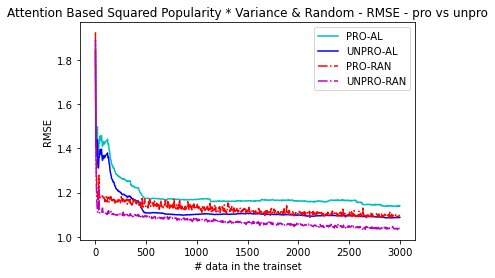

In [49]:
# plt.plot(data_big, rmse_al_pro,'c')
# plt.plot(data_big, rmse_al_unpro,'b')

# plt.plot(data_big, rmse_ran_pro,'r-.')
# plt.plot(data_big, rmse_ran_unpro,'m-.')



# plt.plot(data_med, rmse_al_pro,'c')
# plt.plot(data_med, rmse_al_unpro,'b')

# plt.plot(data_med, rmse_ran_pro,'r-.')
# plt.plot(data_med, rmse_ran_unpro,'m-.')


plt.plot(data_sm, rmse_al_pro,'c')
plt.plot(data_sm, rmse_al_unpro,'b')

plt.plot(data_sm, rmse_ran_pro,'r-.')
plt.plot(data_sm, rmse_ran_unpro,'m-.')



# plt.axis([0,20000,0.5,2.0])
plt.title('Attention Based Squared Popularity * Variance & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['PRO-AL', 'UNPRO-AL', 'PRO-RAN', 'UNPRO-RAN'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE pro vs unpro - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE pro vs unpro - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- RMSE pro vs unpro - small gaps - fixed test.png')


# non parity

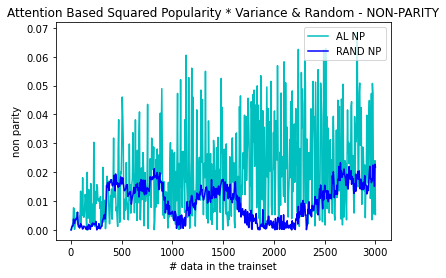

In [50]:
# plt.plot(data_big,np_al,'c')
# plt.plot(data_big,np_ran,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

plt.plot(data_sm,np_al,'c')
plt.plot(data_sm,np_ran,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['AL NP', 'RAND NP'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - NON-PARITY - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - NON-PARITY - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- NON-PARITY - small gaps - fixed test.png')


### value unfairness

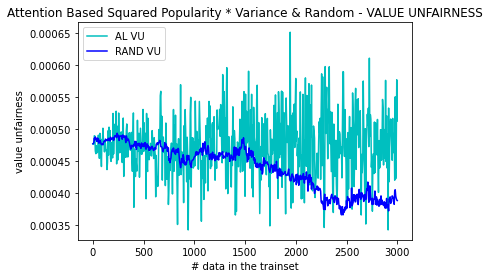

In [51]:
# plt.plot(data_big,vu_al,'c')
# plt.plot(data_big,vu_ran,'b')

# plt.plot(data_med,vu_al,'c')
# plt.plot(data_med,vu_ran,'b')

plt.plot(data_sm,vu_al,'c')
plt.plot(data_sm,vu_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['AL VU', 'RAND VU'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - VALUE UNFAIRNESS - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - VALUE UNFAIRNESS - medium gaps- fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- VALUE UNFAIRNESS - small gaps- fixed test.png')


### absolute unfairness

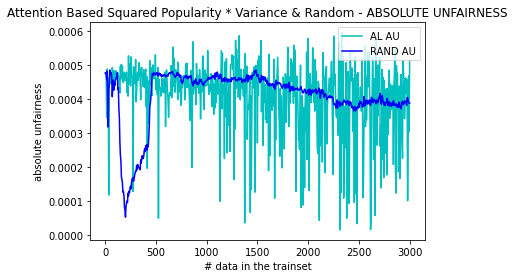

In [52]:
# plt.plot(data_big,au_al,'c')
# plt.plot(data_big,au_ran,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

plt.plot(data_sm,au_al,'c')
plt.plot(data_sm,au_ran,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['AL AU', 'RAND AU'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - ABSOLUTE UNFAIRNESS - big gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - ABSOLUTE UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- ABSOLUTE UNFAIRNESS - small gaps - fixed test.png')


### over estimation unfairness

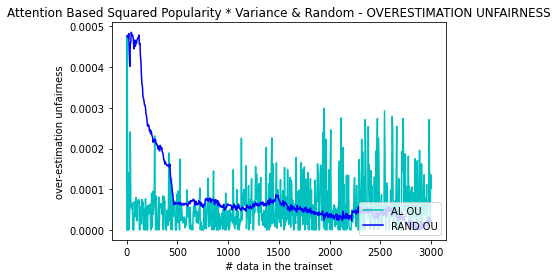

In [53]:
# plt.plot(data_big,ou_al,'c')
# plt.plot(data_big,ou_rand,'b')

# plt.plot(data_med,ou_al,'c')
# plt.plot(data_med,ou_rand,'b')

plt.plot(data_sm,ou_al,'c')
plt.plot(data_sm,ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['AL OU', 'RAND OU'], loc='lower right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - OVERESTIMATION UNFAIRNESS - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - OVERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
- OVERESTIMATION UNFAIRNESS - small gaps - fixed test.png')



### under estimation unfairness

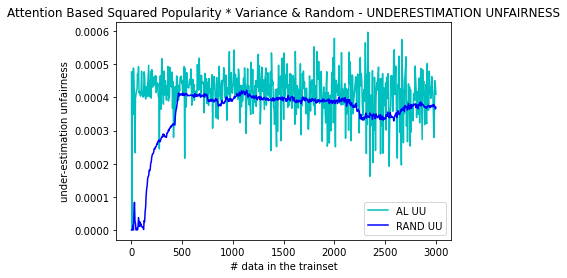

In [54]:
# plt.plot(data_big,uu_al,'c')
# plt.plot(data_big,uu_rand,'b')

# plt.plot(data_med,uu_al,'c')
# plt.plot(data_med,uu_rand,'b')

plt.plot(data_sm,uu_al,'c')
plt.plot(data_sm,uu_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['AL UU', 'RAND UU'], loc='lower right')
# plt.show()
# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - big gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random\
- UNDERESTIMATION UNFAIRNESS - small gaps - fixed test.png')


# Uncertainty Reduction Based on Variance

Uncertainty-reduction are popular strategies
that select items with controversial or diverse ratings.
The system is supposed to be more uncertain about
the users’ opinion about them and asking a user to rate such
items can bring useful (discriminative) information about the
user’s preferences.

this strategy selects the items with the
highest variance, hence, it favours the items that have
been rated diversely by the users on the assumption that
the variance gives an indication of the uncertainty of the
system about that item’s ratings :
$$Variance(i) = 1/|Ui| \sum
u∈Ui
(rui − ¯ri)2$$

In [55]:
# 16 gaps of data

# data = []
# for i in range(101):
#     data.append((i*200))
# data[0] = 1

# A reader is still needed but only the rating_scale param is requiered.

reader = Reader(rating_scale=(1, 5))

# We'll use the famous SVD algorithm.

algo = SVD()

# Active learning 3 - Uncertainty Reduction Variance

df_1 = df.pivot(index = 'user', columns ='item', values = 'rating').fillna(0)

df_numpy = df_1.values

np.warnings.filterwarnings('ignore')

df_mask = df_numpy > 0
df_mask = df_mask.astype(int)

rmse_al = []
rmse_ran = []

# for fairness metrics
rmse_al_pro = []
rmse_al_unpro = []

rmse_ran_pro = []
rmse_ran_unpro = []

np_al = []
np_ran = []

vu_al = []
vu_ran = []

au_al = []
au_ran = []

ou_al = []
ou_rand = []

uu_al = []
uu_rand = []

# Calcul variance for each user/item

tstart = datetime.now()

colVariance = []
for eachCol in df_numpy.T:
    colVariance.append(np.nanvar(eachCol))

item = np.array(colVariance)

item = item.reshape(len(item),1)

var = pd.DataFrame(item, columns=['variance'])

# # Find the maximum - most uncertain ratings about item

maximum = float(var.max())
minimum = float(var.min())

trainact = pd.DataFrame(columns=['user','item','rating'])

while maximum > minimum:
    ind = int(var.idxmax())
    trainact = trainact.append(df.loc[df['item']==(ind+1)],ignore_index = True)
    var = var.drop(index = ind)
    maximum = float(var.max())

trainact = trainact.drop_duplicates()

tend = datetime.now()

# test set
test = df.sample(n = 20000,random_state=1)

# for i in data_big:
# for i in data_med:
for i in data_sm:

    algo = SVD()
    algoran = SVD()

    trainact1 = pd.concat([test, trainact]).drop_duplicates(keep=False)
    trainact1 = trainact1.head(i)

    train = pd.concat([df, test]).drop_duplicates(keep=False)
    train = train.sample(n = i)

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']],
                                       reader).build_full_trainset()
    
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
    
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

    #### active learning ####
    algo.fit(trainsetact)
    predictions = algo.test(testset)

    rmse_al.append(accuracy.rmse(predictions, verbose=False))

    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictions)    
    rmse_al_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_al_unpro.append(accuracy.rmse(unpro_pr, verbose=False)) 
    
    
    #### random ####
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    rmse_ran.append(accuracy.rmse(predictionsran, verbose=False))
    
    
    # pro & unpro RMSE
    pro_pr, unpro_pr = seperate_preds(predictionsran)    
    rmse_ran_pro.append(accuracy.rmse(pro_pr, verbose=False))
    rmse_ran_unpro.append(accuracy.rmse(unpro_pr, verbose=False))
    
    
    ##### consumer side fairness metrics
    # fairness metrics
    preds_df = pd.DataFrame(predictions)
    preds_al_df = pd.DataFrame(predictionsran)
    
    # non-parity
    np_al.append(non_parity(preds_al_df))
    np_ran.append(non_parity(preds_df))
    
    # value unfairness
    vu_al.append(value_unfairness(preds_al_df))
    vu_ran.append(value_unfairness(preds_df))
    
    # absolute unfairness
    au_al.append(abs_unfairness(preds_al_df))
    au_ran.append(abs_unfairness(preds_df))
    
    # over-estimation unfairness
    ou_al.append(overestimation_unfairness(preds_al_df))
    ou_rand.append(overestimation_unfairness(preds_df))
    
    #under-estimation unfairness
    uu_al.append(underestimation_unfairness(preds_al_df))
    uu_rand.append(underestimation_unfairness(preds_df))
    

# print(rmse_al)
print(" Active learning in ms : ")
print(tend-tstart)
# print(rmse_ran)

 Active learning in ms : 
0:00:07.498125


The previous methods are all non-personalized! Simpler active learning strategies do not take into account users’ previously expressed ratings and request all the users to rate the same items. We refer to these strategies as nonpersonalized. In this case, the heuristic used for item selection
does not depend on the profile of the individual users.

These strategies can be static or adaptive during time. (for later)

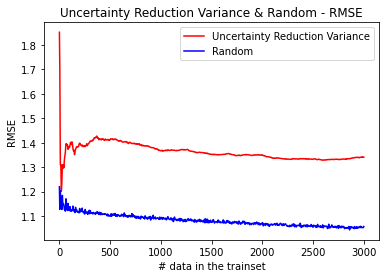

In [56]:

# plt.plot(data_big, rmse_al,'r')
# plt.plot(data_big, rmse_ran,'b')

# plt.plot(data_med, rmse_al,'r')
# plt.plot(data_med, rmse_ran,'b')

plt.plot(data_sm, rmse_al,'r')
plt.plot(data_sm, rmse_ran,'b')

# plt.axis([0,20000,0.5,2])
plt.title('Uncertainty Reduction Variance & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['Uncertainty Reduction Variance', 'Random'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random \
# - RMSE - big gap - fized test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random \
# - RMSE - medium gap - fixed test.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random \
- RMSE - small gap - fixed test.png')


# pro vs unpro

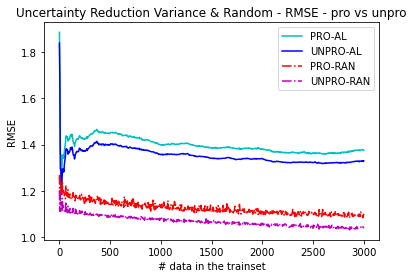

In [57]:
# plt.plot(data_big,rmse_al_pro,'c')
# plt.plot(data_big,rmse_al_unpro,'b')

# plt.plot(data_big,rmse_ran_pro,'r-.')
# plt.plot(data_big,rmse_ran_unpro,'m-.')


# plt.plot(data_med,rmse_al_pro,'c')
# plt.plot(data_med,rmse_al_unpro,'b')

# plt.plot(data_med,rmse_ran_pro,'r-.')
# plt.plot(data_med,rmse_ran_unpro,'m-.')


plt.plot(data_sm, rmse_al_pro,'c')
plt.plot(data_sm, rmse_al_unpro,'b')

plt.plot(data_sm, rmse_ran_pro,'r-.')
plt.plot(data_sm, rmse_ran_unpro,'m-.')


# plt.axis([0,20000,0.5,2.0])
plt.title('Uncertainty Reduction Variance & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['PRO-AL', 'UNPRO-AL', 'PRO-RAN', 'UNPRO-RAN'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - RMSE - pro vs unpro - big gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - RMSE - pro vs unpro - medium gap - fixed test.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- RMSE - pro vs unpro - small gap - fixed test.png')

# non parity

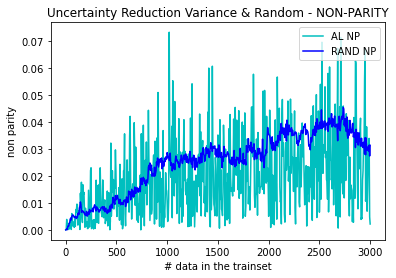

In [58]:
# plt.plot(data_big,np_al,'c')
# plt.plot(data_big,np_ran,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

plt.plot(data_sm, np_al,'c')
plt.plot(data_sm, np_ran,'b')


# plt.axis([0,20000,0.0,0.25])
plt.title('Uncertainty Reduction Variance & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['AL NP', 'RAND NP'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - NON-PARITY - big gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - NON-PARITY - medium gap - fixed test.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- NON-PARITY - small gap - fixed test.png')

### value unfairness

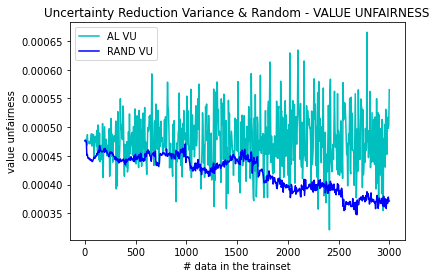

In [59]:
# plt.plot(data_big,vu_al,'c')
# plt.plot(data_big,vu_ran,'b')

# plt.plot(data_med,vu_al,'c')
# plt.plot(data_med,vu_ran,'b')

plt.plot(data_sm,vu_al,'c')
plt.plot(data_sm,vu_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['AL VU', 'RAND VU'], loc='upper left')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - VALUE UNFAIRNESS - big gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - VALUE UNFAIRNESS - medium gap - fixed test.png')


plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- VALUE UNFAIRNESS - small gap - fixed test.png')

### absolute unfairness

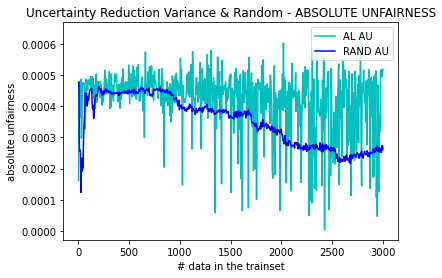

In [60]:
# plt.plot(data_big,au_al,'c')
# plt.plot(data_big,au_ran,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

plt.plot(data_sm,au_al,'c')
plt.plot(data_sm,au_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['AL AU', 'RAND AU'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - ABSOLUTE UNFAIRNESS - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - ABSOLUTE UNFAIRNESS - medium gap.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- ABSOLUTE UNFAIRNESS - small gap.png')

### over estimation unfairness

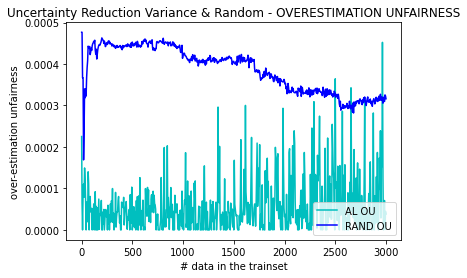

In [61]:
# plt.plot(data_big,ou_al,'c')
# plt.plot(data_big,ou_rand,'b')

# plt.plot(data_med,ou_al,'c')
# plt.plot(data_med,ou_rand,'b')

plt.plot(data_sm,ou_al,'c')
plt.plot(data_sm,ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['AL OU', 'RAND OU'], loc='lower right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - OVERESTIMATION UNFAIRNESS - big gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - OVERESTIMATION UNFAIRNESS - medium gap - fixed test.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- OVERESTIMATION UNFAIRNESS - small gap - fixed test.png')

### under estimation unfairness

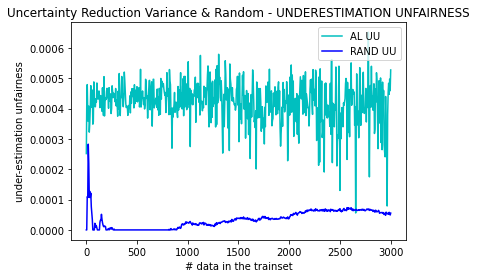

In [62]:
# plt.plot(data_big,uu_al,'c')
# plt.plot(data_big,uu_rand,'b')

# plt.plot(data_med,uu_al,'c')
# plt.plot(data_med,uu_rand,'b')

plt.plot(data_sm,uu_al,'c')
plt.plot(data_sm,uu_rand,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['AL UU', 'RAND UU'], loc='upper right')
# plt.show()
# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - big gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gap - fixed test.png')

plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
- UNDERESTIMATION UNFAIRNESS - small gap - fixed test.png')

In [63]:
pwd

'/Users/nasim/Documents/Data Minimization/source code/Active-Learning-in-Recommender-System'